In [1]:
from LinearControlSystem import LinearControlSystem

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.signal import find_peaks

# Assignment 3

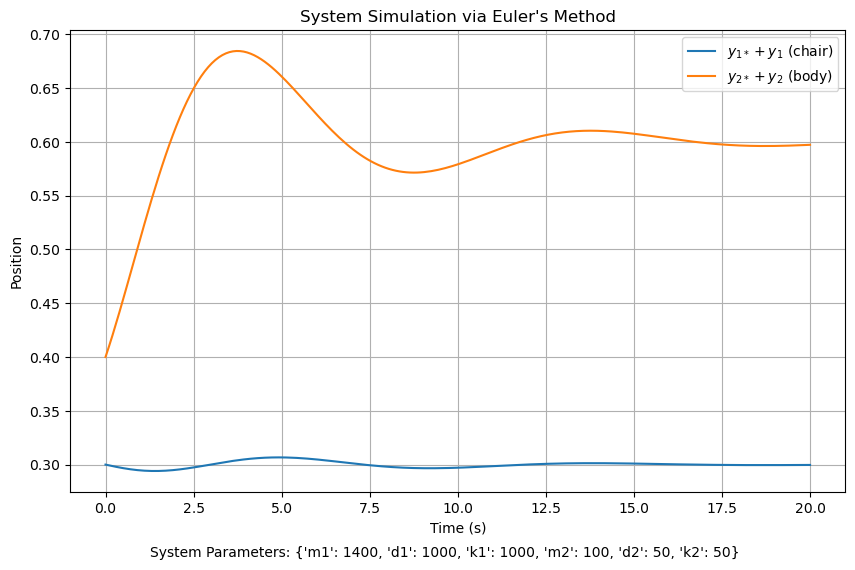

Eigenvalues: [-0.40399063+0.80297748j -0.40399063-0.80297748j -0.22100937+0.62703556j
 -0.22100937-0.62703556j]


In [16]:
u = lambda t: 0
z = lambda t: 1*t

input_parameters = {"m1":1400, "d1": 1000, "k1": 1000,
                    "m2": 100, "d2": 50, "k2": 50}


initial_conditions = {"x1": 0, "x2": 0, "x3": 0, "x4": -0.2} 
model = LinearControlSystem(input_parameters, u=u, z=z, time=20)
model.solve(initial_conditions)
model.plot()
model.compute_eigenvalues()


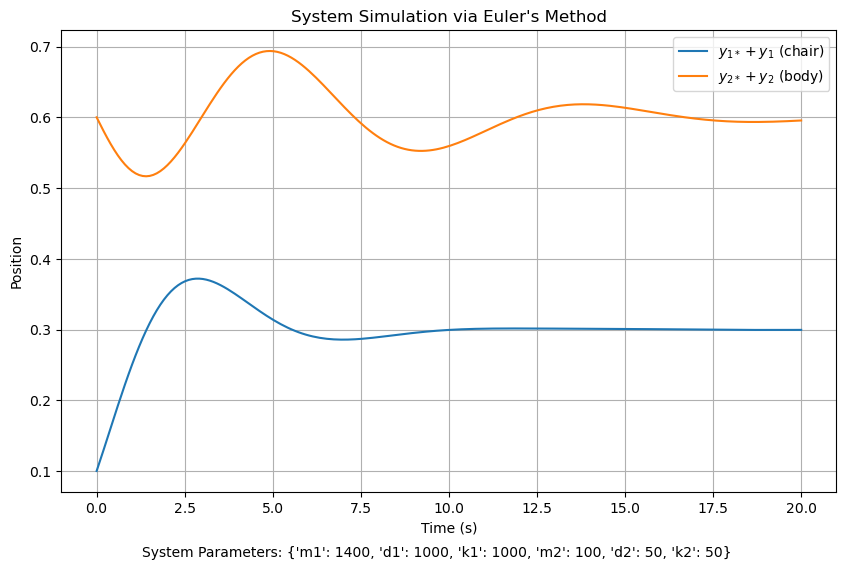

Eigenvalues: [-0.40399063+0.80297748j -0.40399063-0.80297748j -0.22100937+0.62703556j
 -0.22100937-0.62703556j]


In [17]:
u = lambda t: 0
z = lambda t: 1*t

initial_conditions = {"x1": 0, "x2": -0.2, "x3": 0, "x4": 0} 
model = LinearControlSystem(input_parameters, u=u, z=z, time=20)
model.solve(initial_conditions)
model.plot()
model.compute_eigenvalues()

# Assignment 4

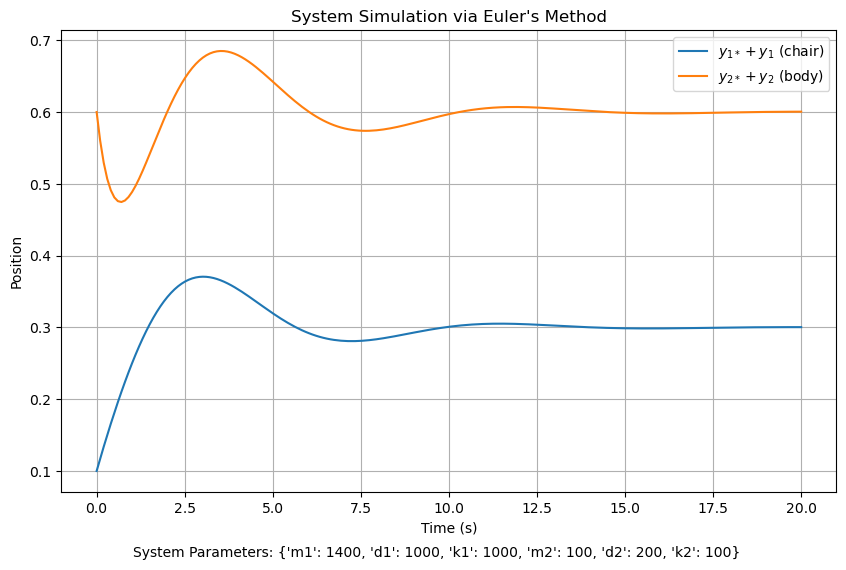

Eigenvalues: [-0.33217084+0.72645271j -0.33217084-0.72645271j -1.38388755+0.j
 -0.80891364+0.j        ]


In [18]:
u = lambda t: 0
z = lambda t: 1*t

input_parameters = {"m1":1400, "d1": 1000, "k1": 1000,
                    "m2": 100, "d2": 200, "k2": 100}
initial_conditions = {"x1": 0, "x2": -0.2, "x3": 0, "x4": 0} 

model = LinearControlSystem(input_parameters, u=u, z=z, time=20)
model.solve(initial_conditions)
model.plot()
model.compute_eigenvalues()

# Assignment 5

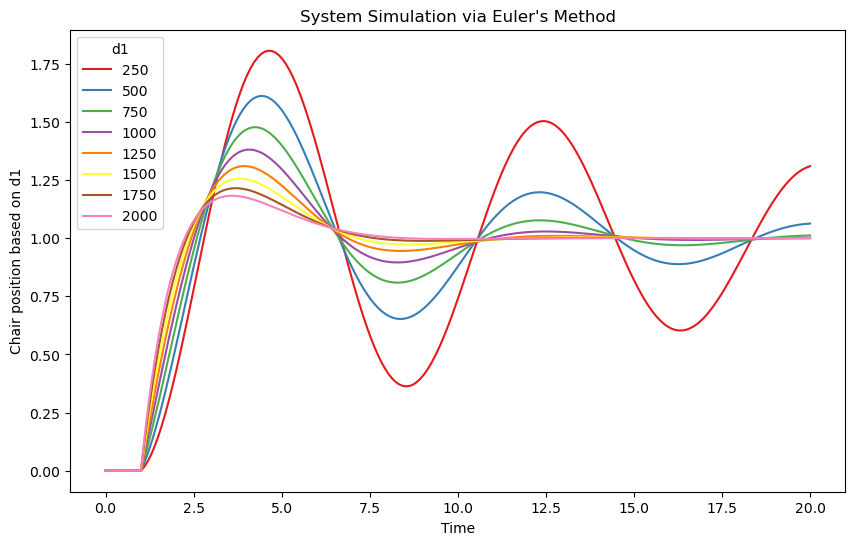

In [19]:
u = lambda t: 0 if t<1 else 1
z = lambda t: 1*t

initial_conditions = {"x1": 0, "x2": 0, "x3": 0, "x4": 0} 

df_list = []

for d1 in np.arange(250,2000+1,250):

    input_parameters = {"m1":1400, "d1": d1, "k1": 1000,
                    "m2": 100, "d2": 200, "k2": 100}
    model = LinearControlSystem(input_parameters, u=u, z=z, time=20)
    model.solve(initial_conditions)
    df = model.get_y1()
    df_list.append(df)

df = pd.concat(df_list)

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='time_steps', y='y1', hue='d1', palette='Set1')
plt.title('Position vs Time with Categorical Variable')
plt.title("System Simulation via Euler's Method")
plt.xlabel('Time')
plt.ylabel('Chair position based on d1')

plt.legend(title='d1')
plt.show()

# Assignment 6

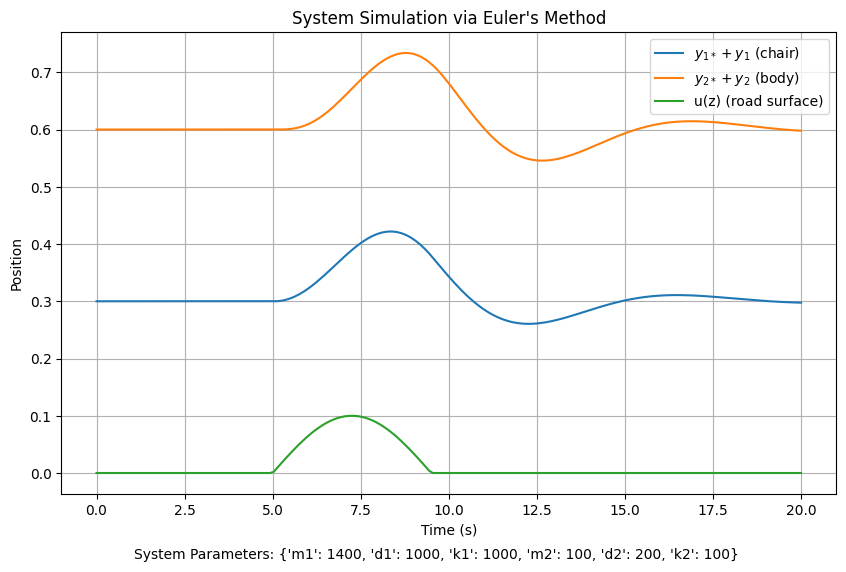

Maximum Elevation Difference (y2 - y1): 0.0384 m
Time of Maximum Elevation: t = 9.8492 s
Eigenvalues: [-0.33+0.73j -0.33-0.73j -1.38+0.j   -0.81+0.j  ]


In [ ]:
s = 3
z = lambda t: s*t
u = lambda z: 0.1 * np.cos(-0.6981*(z/s-7.25)) if 5 <= z/s <= 9.5 else 0

input_parameters = {"m1":1400, "d1": 1000, "k1": 1000,
                    "m2": 100, "d2": 200, "k2": 100}
initial_conditions = {"x1": 0, "x2": 0, "x3": 0, "x4": 0} 

model = LinearControlSystem(input_parameters, u=u, z=z, time=20)
model.solve(initial_conditions)
model.plot(plot_u=True)
model.compute_max_elevation()
model.compute_eigenvalues()

# Assignment 7

Bump s=1.5

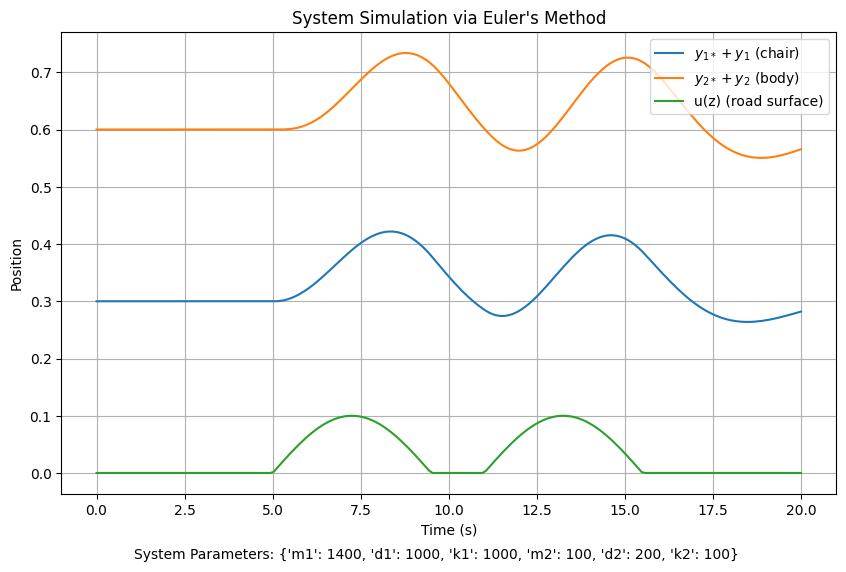

Maximum Elevation Difference (y2 - y1): 0.0384 m
Time of Maximum Elevation: t = 9.8492 s
Eigenvalues: [-0.33+0.73j -0.33-0.73j -1.38+0.j   -0.81+0.j  ]


In [ ]:
s = 1.5
z = lambda t: s*t
u = lambda z: 0.1 * np.cos(-0.6981*(z/s-7.25)) if 5 <= z/s <= 9.5 else 0

u_s1_5 = lambda z: 0.1 * np.cos(-0.6981*(z/s-7.25-(4.5+1.5))) if 11 <= z/s <= 15.5 else 0
u_sum1_5 = lambda z: u(z)+u_s1_5(z)

input_parameters = {"m1":1400, "d1": 1000, "k1": 1000,
                    "m2": 100, "d2": 200, "k2": 100}
initial_conditions = {"x1": 0, "x2": 0, "x3": 0, "x4": 0} 

model = LinearControlSystem(input_parameters, u=u_sum1_5, z=z, time=20)
model.solve(initial_conditions)
model.plot(plot_u=True)
model.compute_max_elevation()
model.compute_eigenvalues()

Bump s=0

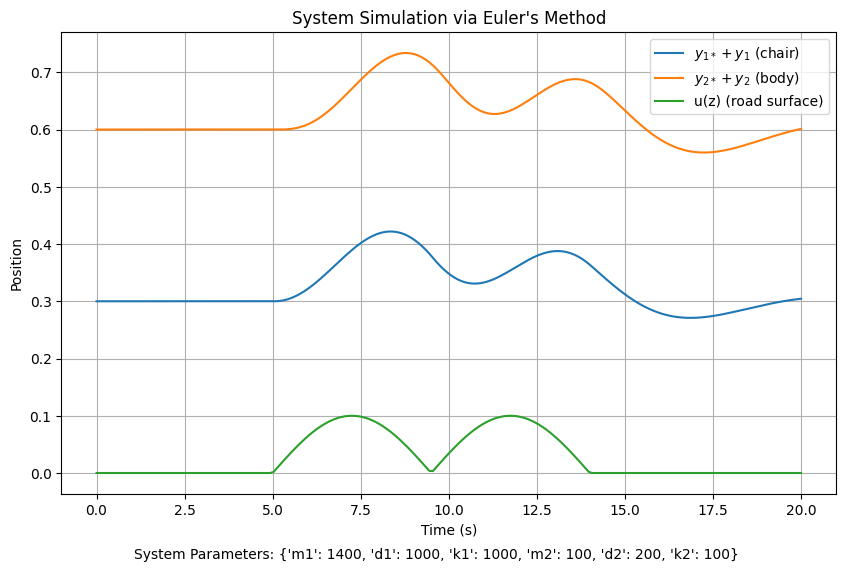

Maximum Elevation Difference (y2 - y1): 0.0373 m
Time of Maximum Elevation: t = 9.7487 s
Eigenvalues: [-0.33+0.73j -0.33-0.73j -1.38+0.j   -0.81+0.j  ]


In [ ]:
s = 1.5
z = lambda t: s*t
u = lambda z: 0.1 * np.cos(-0.6981*(z/s-7.25)) if 5 <= z/s <= 9.5 else 0

u_s0 = lambda z: 0.1 * np.cos(-0.6981*(z/s-7.25-(4.5))) if 9.5 <= z/s <= 14 else 0
u_sum0 = lambda z: u(z)+u_s0(z)

input_parameters = {"m1":1400, "d1": 1000, "k1": 1000,
                    "m2": 100, "d2": 200, "k2": 100}
initial_conditions = {"x1": 0, "x2": 0, "x3": 0, "x4": 0} 

model = LinearControlSystem(input_parameters, u=u_sum0, z=z, time=20)
model.solve(initial_conditions)
model.plot(plot_u=True)
model.compute_max_elevation()
model.compute_eigenvalues()

# Assignment 8

Speed = 3m/s

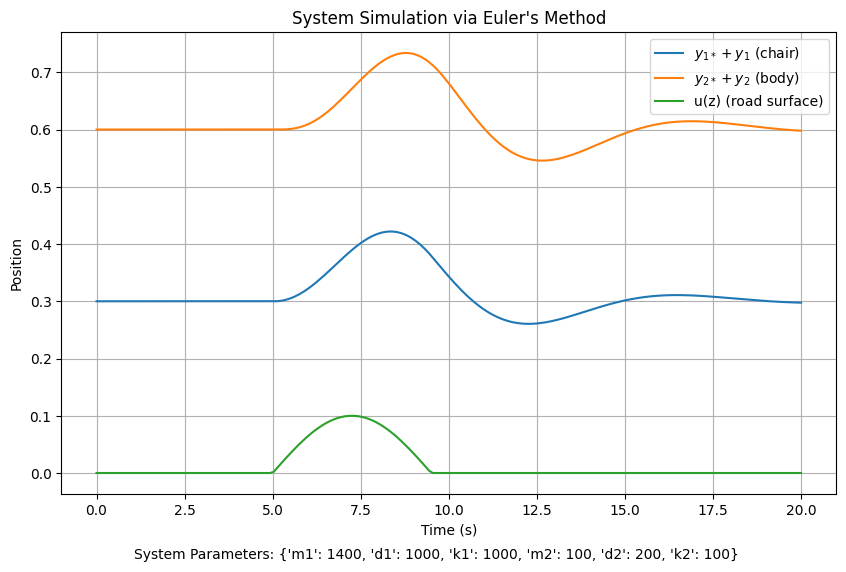

Maximum Elevation Difference (y2 - y1): 0.0384 m
Time of Maximum Elevation: t = 9.8492 s
Eigenvalues: [-0.33+0.73j -0.33-0.73j -1.38+0.j   -0.81+0.j  ]


In [33]:
s = 3
z = lambda t: s*t
u = lambda z: 0.1 * np.cos(-0.6981*(z/s-7.25)) if 5 <= z/s <= 9.5 else 0

input_parameters = {"m1":1400, "d1": 1000, "k1": 1000,
                    "m2": 100, "d2": 200, "k2": 100}
initial_conditions = {"x1": 0, "x2": 0, "x3": 0, "x4": 0} 

model = LinearControlSystem(input_parameters, u=u, z=z, time=20)
model.solve(initial_conditions)
model.plot(plot_u=True)
model.compute_max_elevation()
model.compute_eigenvalues()

Speed = 10 m/s

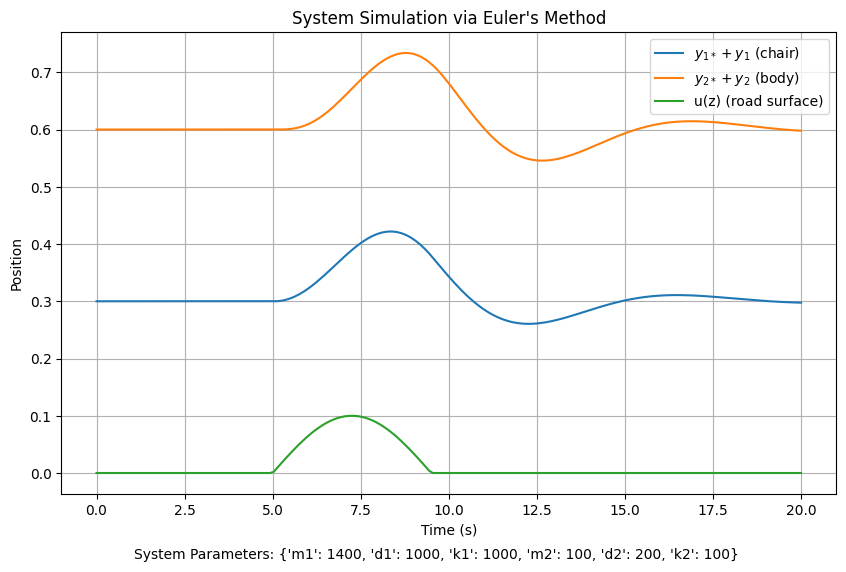

Maximum Elevation Difference (y2 - y1): 0.0384 m
Time of Maximum Elevation: t = 9.8492 s
Eigenvalues: [-0.33+0.73j -0.33-0.73j -1.38+0.j   -0.81+0.j  ]


In [ ]:
s = 10
z = lambda t: s*t
u = lambda z: 0.1 * np.cos(-0.6981*(z/s-7.25)) if 5 <= z/s <= 9.5 else 0

input_parameters = {"m1":1400, "d1": 1000, "k1": 1000,
                    "m2": 100, "d2": 200, "k2": 100}
initial_conditions = {"x1": 0, "x2": 0, "x3": 0, "x4": 0} 

model = LinearControlSystem(input_parameters, u=u, z=z, time=20)
model.solve(initial_conditions)
model.plot(plot_u=True)
model.compute_max_elevation()
model.compute_eigenvalues()

# Assignment 9

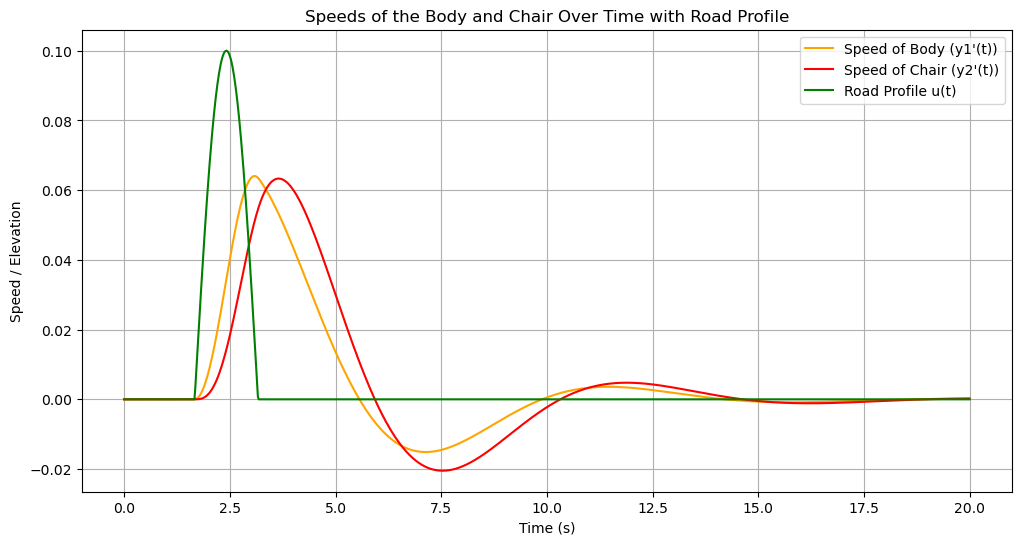

Is the speed of the car body differentiable? Yes
Is the speed of the chair differentiable? Yes


In [7]:
u = lambda z: 0.1 * np.cos(-0.6981*(z-7.25)) if 5 <= z <= 9.5 else 0
z = lambda t: 3*t

m1, d1, k1 = 1400, 1000, 1000
m2, d2, k2 = 100, 200, 100

A = np.array([
    [0, -(k2 + k1) / m1, 0, k2 / m1],
    [1, -(d2 + d1) / m1, 0, d2 / m1],
    [0, k2 / m2, 0, -k2 / m2],
    [0, d2 / m2, 1, -d2 / m2]
])

B = np.array([k1 / m1, d1 / m1, 0, 0]).reshape(-1, 1)

C = np.array([
    [0, 1, 0, 0],  # y1'(t)
    [0, 0, 0, 1]   # y2'(t)
])

t_values = np.linspace(0, 20, 1000)  # 1000 points for smooth plotting
z_values = z(t_values)
u_values = np.array([u(z) for z in z_values])

def system(t, x):
    z_t = z(t) 
    u_t = u(z_t)
    return (A @ x + B.flatten() * u_t)

initial_conditions = np.array([0, 0, 0, 0])

solution = solve_ivp(system, [0, 20], initial_conditions, t_eval=t_values, method='RK45')

x_solution = solution.y.T  # Shape: (time steps, 4)

y_prime_values = (C @ x_solution.T).T

y1_prime_values = y_prime_values[:, 0]
y2_prime_values = y_prime_values[:, 1]

plt.figure(figsize=(12, 6))
plt.plot(t_values, y1_prime_values, label="Speed of Body (y1'(t))", color='orange')
plt.plot(t_values, y2_prime_values, label="Speed of Chair (y2'(t))", color='red')
plt.plot(t_values, u_values, label="Road Profile u(t)", color='green')

plt.xlabel("Time (s)")
plt.ylabel("Speed / Elevation")
plt.title("Speeds of the Body and Chair Over Time with Road Profile")
plt.legend()
plt.grid()
plt.show()

# Compute numerical second derivative to check differentiability and find potential peaks of non-differentiability
y1_double_prime_values = np.gradient(y1_prime_values, t_values)
y2_double_prime_values = np.gradient(y2_prime_values, t_values)

y1_peaks, _ = find_peaks(np.abs(y1_double_prime_values), height=1)
y2_peaks, _ = find_peaks(np.abs(y2_double_prime_values), height=1)

is_y1_differentiable = len(y1_peaks) == 0
is_y2_differentiable = len(y2_peaks) == 0

print(f"Is the speed of the car body differentiable? {'Yes' if is_y1_differentiable else 'No'}")
print(f"Is the speed of the chair differentiable? {'Yes' if is_y2_differentiable else 'No'}")
